***************************************************************************************
Jupyter Notebooks from the Metadata for Everyone project

Code:
* Dennis Donathan II (https://orcid.org/0000-0001-8042-0539)

Project team: 
* Juan Pablo Alperin (https://orcid.org/0000-0002-9344-7439)
* Dennis Donathan II (https://orcid.org/0000-0001-8042-0539)
* Mike Nason (https://orcid.org/0000-0001-5527-8489)
* Julie Shi (https://orcid.org/0000-0003-1242-1112)
* Marco Tullney (https://orcid.org/0000-0002-5111-2788)

Last updated: xxx
***************************************************************************************

# Language Detection

In the previous notebook, we found that a significant number of records are missing a stated *language* within the record. Additionally, we found in our work in phase 1 of our project (see Shi, J., Nason, M., Tullney, M., & Alperin, J. P. (2023). Identifying Metadata Quality Issues Across Cultures. SocArXiv. https://doi.org/10.31235/osf.io/6fykh)) it is not uncommon for the stated language of the record to be inaccurate. This could be for a variety of reasons: lack of clarity as to what *language* is actually referring to (i.e. the language of the item, container, or the metadata record itself), perhaps some level of increased discoverability if the work is labeled with **en** (English).

To examine these issues more closely, we will detect the languages used within the records, compare that against their stated languages, and see any patterns that emerge.



## Preparation 
First we will import several of the necessary packages, set up our directory, and import our data.

In [2]:
import seaborn as sns # data visualizations
from pathlib import Path
import numpy as np
import pandas as pd #Creating dataframe and manipulating data
from nltk.tokenize import sent_tokenize
from py3langid.langid import LanguageIdentifier, MODEL_FILE
from matplotlib import pyplot as plt
from typing import List, Dict, Optional

In [3]:
# Data Directory
data_dir = Path('../data')
input_dir = data_dir / 'input'
output_dir = data_dir / 'output'
# Loading in dataset
df = pd.read_parquet(output_dir / '03_labeled_data.parquet')
#df = df_all.loc[df_all.abstracts.notnull()]

## Detecting Languages
We'll use `py3langid` as we did previously, with the same language list as before. While `py3langid` is optimized for python3 and is several times faster than the original, it is important to note that due to the nature of the language detection we will be doing, it may take a minute or two, but no longer than that. We will check each record across three fields, *abstract*, *title*, and *container-title*. These are the fields that have some of the most text, and thus can give us the most confident results. We'll set a probability threshold of `.95` to help insure that we are only saying a language is present when the model is very confident.

### Matching
After detecting the langauge used in the records, we will then see if the `detected_lang` matches the record's stated *language*. In doing this we will label the record with a `0` if the stated language matches detected language, `1` if the stated language **does not** match detected language), or `2` if the multiple detected languages, but one of the detected languages matches the stated language). 

### Language Type
Finally, we will apply an additional code to each record: `0` if the detected language is English, `1` if the detected language is any single non-english language, `2` for multilingual records.

In [4]:
identifier = LanguageIdentifier.from_pickled_model(MODEL_FILE, norm_probs = True)
lang_list = ['af', 'am', 'ar', 'as', 'az', 'be', 'bg', 'bn', 'br', 
             'bs', 'ca', 'cs', 'cy', 'da', 'de', 'dz', 'el', 'en', 'eo', 
             'es', 'et', 'eu', 'fa', 'fi', 'fo', 'fr', 'ga', 'gl', 'gu', 
             'he', 'hi', 'hr', 'ht', 'hu', 'hy', 'is', 'it', 'ja', 'jv', 
             'ka', 'kk', 'km', 'kn', 'ko', 'ku', 'ky', 'la', 'lb', 'lo', 
             'lt', 'lv', 'mg', 'mk', 'ml', 'mn', 'mr', 'ms', 'mt', 'ne', 
             'nl', 'no', 'oc', 'or', 'pa', 'pl', 'ps', 'pt', 'qu', 'ro', 
             'ru', 'rw', 'se', 'si', 'sk', 'sl', 'sq', 'sr', 'sv', 'sw', 
             'ta', 'te', 'th', 'tl', 'tr', 'ug', 'uk', 'ur', 'vi', 'vo', 
             'wa', 'xh', 'zh', 'zu']
identifier.set_languages(langs=lang_list)
# Check across multiple fields within each record for the languages present.
def record_lang_checker(abstracts: List[str]) -> Optional[List[str | None]]:
    #These fields have the most text which will provide the most accurate language detection
    #fields = ['abstract', 'title', 'container-title']
    #fields = ['abstract']
    lang_list = []
    #for col in fields:
    try:
        for abstract in abstracts:
            tokenized = sent_tokenize(abstract)
            for i in tokenized:
                detect = identifier.classify(i.lower())
                # Setting a .95 probability threshold for asserting the language is indeed in the record
                if detect[1] > .95:
                    lang_list.append(detect[0])
                else:
                    pass
    except:
        return None
    #If no language is detected, return None
    if len(lang_list) == 0:
        return None
    else:
        #Returning all of the detected languages for each record
        return list(set(lang_list))


In [5]:
df['detected_lang'] = df.abstracts.map(lambda x: record_lang_checker(x))
detected_languages = df.explode('detected_lang')
#detected_languages.detected_lang.nunique()

In [6]:
print("{:0.0f} different languages have been detected in the sample.".format(detected_languages.detected_lang.nunique()))

81 different languages have been detected in the sample.


In [7]:
detected_languages['detected_lang'].value_counts().head(20)

detected_lang
en    113697
pt      4865
es      4033
fr      3567
ms      3204
de      3107
ru       836
tr       759
la       479
uk       462
pl       359
it       263
ar       242
zh       208
hr       190
nl       163
hu       146
vi       131
da        85
lt        84
Name: count, dtype: int64

In [8]:
df['detected_lang'].value_counts().head(20)

detected_lang
[en]        105334
[pt]          3181
[es]          3067
[ms]          2355
[de]          1993
[en, fr]      1968
[fr]          1121
[pt, en]       829
[en, ms]       732
[en, de]       427
[ru]           422
[uk]           415
[tr, en]       396
[en, pt]       391
[en, la]       389
[de, en]       372
[en, es]       338
[en, ru]       336
[pl]           269
[ar]           213
Name: count, dtype: int64

In [10]:
df.journal_lang.value_counts(dropna=False)

journal_lang
en      395068
None    113070
de        8949
fr        5442
es        1364
ja        1336
ru        1205
ar         923
nl         567
ko         368
no         291
pt         231
it         176
ng         169
tr         166
pl         151
uk         143
fa         128
cs          65
nb          52
hu          31
vi          24
zh          16
la          15
af          13
hr          11
id          11
sr          10
bg           8
da           6
uz           6
et           4
lt           4
ca           4
eo           3
sl           2
sv           2
is           2
ka           2
hy           1
ps           1
ro           1
az           1
ur           1
nr           1
Name: count, dtype: int64

In [12]:
def detection_match(record):
    try:
        #Filtering out records with no stated language
        if record['journal_lang'] is None:
            return 3
        else:
            #checking if stated language matches detected language
            if record['journal_lang'] in record['detected_lang']:
                #Stated language is within the detected languages, but there are multiple languages
                #present in the record
                if len(record['detected_lang']) > 1:
                    return 2
                #Stated language matches detected language
                else:
                    return 0
            #Stated and detected languages do not match
            else:
                return 1
    except:
        return 3

In [ ]:
def detection_match_old(record):
    try:
        #Filtering out records with no stated language
        if record['language'] == np.nan:
            return 3
        else:
            #checking if stated language matches detected language
            if record['language'] in record['detected_lang']:
                #Stated language is within the detected languages, but there are multiple languages
                #present in the record
                if len(record['detected_lang']) > 1:
                    return 2
                #Stated language matches detected language
                else:
                    return 0
            #Stated and detected languages do not match
            else:
                return 1
    except:
        return None

In [13]:
df['lang_match'] = df.apply(detection_match, axis=1)
df.lang_match.value_counts()
# 0.0 -> the language indicated matches the detected language
# 1.0 -> there is only one language detected, and the language indicated does not match the detected language
# 2.0 -> there are at least two languages detected, and the language indicated is one of the detected languages
# 3.0 -> there is no indicated language

lang_match
3    442897
0     80535
2      4284
1      2328
Name: count, dtype: int64

In [ ]:
df[['detected_lang', 'language', 'lang_match']]

In [14]:
def lang_type(record):
    try:
        # Records that we've already determined have multilingual content can be assigned
        # their categorization and filtered out
        if record['Multilingual Abstract'] == 1:
            return 'Multilingual'
        else:
            #Checking the monolingual records if they are english or non-english
            if len(record['detected_lang']) == 1:
                if record['detected_lang'][0] == 'en':
                    return 'Monolingual English'
                else:
                    return 'Monolingual Non-English'
            else:
                #Multilingual records
                if len(record['detected_lang']) > 1:
                    return 'Multilingual'
                else:
                    return None
    except:
        return None

df['lang_type'] = df.apply(lang_type, axis=1)
df.lang_type.value_counts(dropna=False)

lang_type
None                       401819
Monolingual English        105195
Monolingual Non-English     14182
Multilingual                 8848
Name: count, dtype: int64

## Analyses by language type

⚠️ So this is where we should try to differentiate RQ1 results by language type. If you have the time, could you try to do "language absent" and "author initials"? I could then try to do a few other important ones. ⚠️

## Differences in Errors Between Language Types
After detecting the languages and coding the records, we can see that there are a large number of records in which the `detected_lang` does not match the stated language. One possible explanation is the high number of records that simply do not have a stated language. We will explore this below.

Additionally, we can see that English is the predominant language of the dataset. Next, we'll take a look at errors per record in regards to the different language types: English-monolingual, Non-English-monolingual, and Multilingual.

First, we'll take a look at the number of errors per language.

In [15]:
grouped_langs = detected_languages.groupby('detected_lang')
group_total_errors = grouped_langs.agg({'Total Errors': 'sum', 'doi': 'count'}).sort_values(by='doi', ascending=False)
group_total_errors[:20]

,Total Errors,doi
detected_lang,,
en,332047.0,113697
pt,17354.0,4865
es,15120.0,4033
fr,12229.0,3567
ms,11753.0,3204
de,12162.0,3107
ru,3724.0,836
tr,2965.0,759
la,1506.0,479


/tmp/ipykernel_22626/1571472067.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)


Text(0.5, 1.0, 'Total Errors by Language')

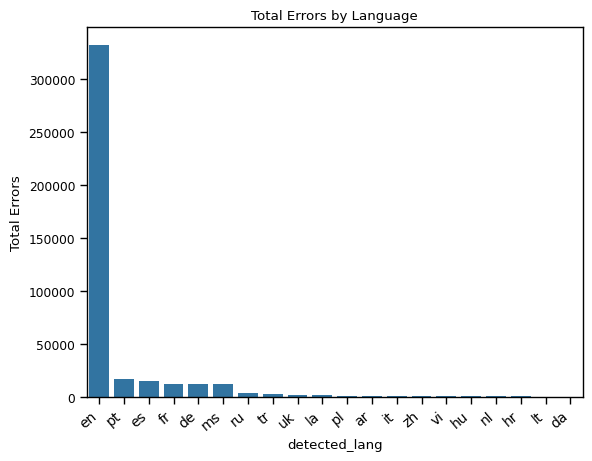

In [16]:
sns.set_context('paper')
top_20 = group_total_errors.sort_values(by='Total Errors', ascending=False)[:20]
t20plt = sns.barplot(data=top_20, x=top_20.index, y='Total Errors')
t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)
t20plt.set_title('Total Errors by Language')

/tmp/ipykernel_21103/454900587.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)


Text(0.5, 1.0, 'Total Errors by Language (excl. English)')

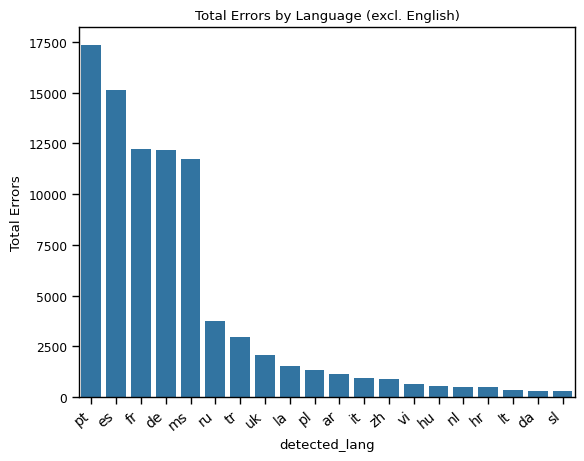

In [33]:
#Now we'll remove English, to better visualize other languages
no_en = group_total_errors.drop('en')
top_20 = no_en.sort_values(by='Total Errors', ascending=False)[:20]
t20plt = sns.barplot(data=top_20, x=top_20.index, y='Total Errors')
t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)
t20plt.set_title('Total Errors by Language (excl. English)')

In [34]:
#Now we'll change from total errors, to the mean number of errors by language
group_avg_errors = grouped_langs.agg({'Total Errors': 'mean', 'doi': 'count'}).sort_values(by='Total Errors', ascending=False)
group_avg_errors

,Total Errors,doi
detected_lang,,
bg,5.179487,39
be,5.100000,10
kk,5.095238,21
fo,5.000000,1
he,5.000000,1
...,...,...
si,2.750000,4
qu,2.750000,4
hr,2.684211,190


/tmp/ipykernel_21103/2566596563.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)


Text(0.5, 1.0, 'Errors per Record by Language')

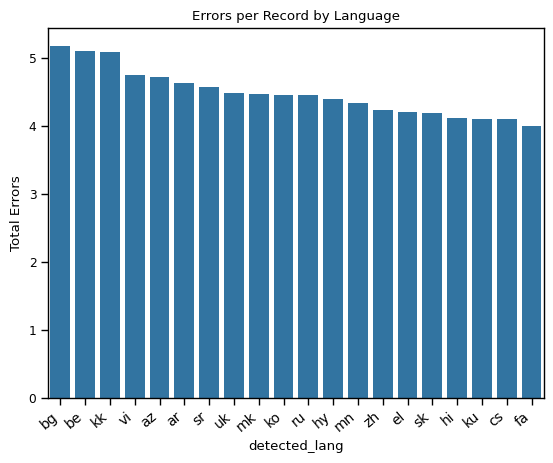

In [36]:
#We'll remove the languages with only a couple of records
filtered = group_avg_errors.loc[group_avg_errors.doi > 5].sort_values(by='Total Errors', ascending=False)
top_20 = filtered[:20]
t20plt = sns.barplot(data=top_20, x=top_20.index, y='Total Errors')
t20plt.set_xticklabels(t20plt.get_xticklabels(), rotation=40, ha='right', fontsize=10)
t20plt.set_title('Errors per Record by Language')

### Individual Languages
We see that, as mentioned, English is by far the most represented language in the dataset, and, consequently, has the most errors. Once removing english, we see that German (de), French (fr), Spanish (es), Portugese (pt), and Malay (ms) are the next top 5 in total errors, but that tends to be a reflection of the quantity of  in the dataset.

However, when we look at the average (arithmetic mean) of the errors per language, we do see that there are a number of languages from the top 20 of total errors there:

Chinese (zh), Russian (ru), Ukranian (uk), Bulgarian (bg), Japanese (ja), Arabic (ar).

Now, we'll take a look at the differences between language types.

In [37]:
multi = df.loc[df.lang_type == 'Multilingual']
non_english = df.loc[df.lang_type == 'Monolingual Non-English']
english = df.loc[df.lang_type == 'Monolingual English']

In [ ]:
#multi["DOI"].head(50)

In [39]:
multi_error_rate = multi['Total Errors'].sum()/len(multi)
eng_error_rate = english['Total Errors'].sum()/len(english)
non_eng_error_rate = non_english['Total Errors'].sum()/len(non_english)

print("{:0.2f} errors per english, monolingual record".format(eng_error_rate))
print("{:0.2f} errors per non-english, monolingual record".format(non_eng_error_rate))
print("{:0.2f} errors per multilingual record".format(multi_error_rate))

2.88 errors per english, monolingual record
3.86 errors per non-english, monolingual record
3.48 errors per multilingual record


To visualize this data, we'll look at the error rates for each of these language types and break them up by their publisher bin.

Then We'll take a look at any differences between the languages.

In [ ]:
#Multilingual Records
#mlt = sns.catplot(data=multi,x='publisher_bin', y='total_errors', kind='bar', height=4, aspect=.8, order=['XS', 'S', 'M', 'L', 'XL'], errorbar=None)
#mlt.set_axis_labels('', 'Error per Record')
#mlt.fig.subplots_adjust(top=0.9)
#mlt.fig.suptitle('Errors per Record by Publisher Size, Multilingual Records')

In [ ]:
#English Monolingual Records
#en_only = sns.catplot(data=english, x='publisher_bin', y='total_errors', kind='bar', height=4, aspect=.8, order=['XS', 'S', 'M', 'L', 'XL'], errorbar=None)
#en_only.set_axis_labels('', 'Error per Record')
#en_only.fig.subplots_adjust(top=0.9)
#en_only.fig.suptitle('Errors per Record by Publisher Size, English Only')

In [ ]:
#Non-English Monolingual Records
#non_en_plt = sns.catplot(data=non_english, x='publisher_bin', y='total_errors', kind='bar', height=4, aspect=.8, order=['XS', 'S', 'M', 'L', 'XL'], errorbar=None)
#non_en_plt.set_axis_labels('', 'Error per Record')
#non_en_plt.fig.subplots_adjust(top=0.9)
#non_en_plt.fig.suptitle('Errors per Record by Publisher Size, Monolingual Records (non-English)')

### Differences in Language Types
We can see that the publisher bins generally change between groups in a similar fashion. The error rate for all seems to be highest in non-English monolingual records, and at its lowest in English monolingual records.

Consistent throughout all groups the XS publisher bin has the highest error rate.

Finally, we'll take a look to see any differences in the presence of a stated language between the language types.

In [40]:
multi_no_lang = (multi.journal_lang.isna().sum()/len(multi)) *100
eng_no_lang = (english.journal_lang.isna().sum()/len(english)) *100
non_eng_no_lang = (non_english.journal_lang.isna().sum()/len(non_english)) * 100

print("{:0.2f}% english, monolingual records with no stated language".format(eng_no_lang))
print("{:0.2f}% non_english, monolingual records with no stated language".format(non_eng_no_lang))
print("{:0.2f}% multilingual records with no stated language".format(multi_no_lang))

23.84% english, monolingual records with no stated language
81.77% non_english, monolingual records with no stated language
49.71% multilingual records with no stated language


<function matplotlib.pyplot.show(close=None, block=None)>

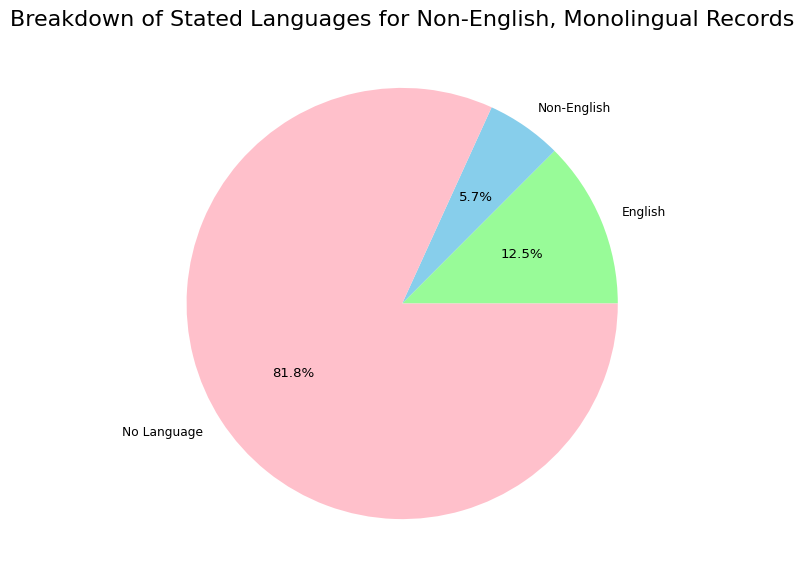

In [42]:
def en_stated(lang):
    try:
        if lang == 'en':
            return 1
        elif lang in lang_list:
            return 0
        else:
            return None
    except:
        return None
    
find_stated = non_english.journal_lang.map(lambda x: en_stated(x))
enStated = find_stated.sum()
nonenStated = len(find_stated.loc[find_stated == 0])
non_eng_no_lang = non_english.journal_lang.isna().sum()
labels = ['English', 'Non-English', 'No Language']
data = [enStated, nonenStated, non_eng_no_lang]
colors = ['palegreen','skyblue', 'pink']
fig = plt.figure(figsize = (10,7))
plt.pie(data, labels = labels, autopct='%.1f%%', colors=colors)
plt.title('Breakdown of Stated Languages for Non-English, Monolingual Records', fontsize=16)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

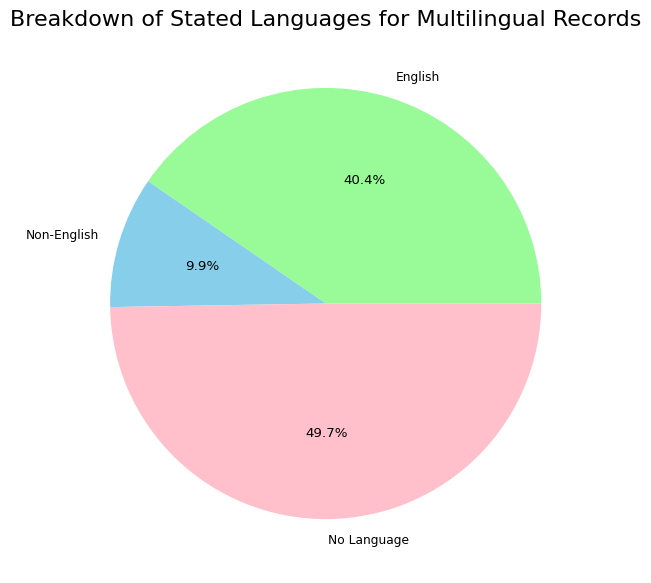

In [43]:
find_stated = multi.journal_lang.map(lambda x: en_stated(x))
enStated = find_stated.sum()
nonenStated = len(find_stated.loc[find_stated == 0])
multi_no_lang = multi.journal_lang.isna().sum()
labels = ['English', 'Non-English', 'No Language']
data = [enStated, nonenStated, multi_no_lang]
colors = ['palegreen','skyblue', 'pink']
fig = plt.figure(figsize = (10,7))
plt.pie(data, labels = labels, autopct='%.1f%%', colors=colors)
plt.title('Breakdown of Stated Languages for Multilingual Records', fontsize=16)
plt.show

In [44]:
#Looking to see how many multilingual records use english within their records
def has_english(langlist):
    try:
        if 'en' in langlist:
            return 1
        else:
            return 0
    except:
        return None
eng_multi = multi.detected_lang.map(lambda x: has_english(x))
eng_having_rate = (eng_multi.sum()/len(multi)) *100
print("{:0.2f}% of multilingual records have English as one of their languages".format(eng_having_rate))

96.09% of multilingual records have English as one of their languages


In [17]:
df.to_parquet(output_dir / '04_language_detection.parquet')